# Data
We will build a class ReutersSGMLParser that inherits HTMLParser. We override three methods, handle_starttag, handle_endtag and handle_data. These methods tell the parser what to do at the beginning and closing of SGML tags, and how to handle the data in between. Additional methods reset and parse resets the state of the tags and parses the documents respectively.

In [274]:
from html.parser import HTMLParser
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix


class ReutersSGMLParser(HTMLParser):
    """
    This class is used to open the sgm files in the reuters21578.
    
    Data will be chunked on parsing. bool_in_body, bool_in_topics and bool_in_topic_d kee
    keep track of internal state of when tags have been "entered" and "exited".

    """
    def __init__(self, encoding='latin-1'):
        """
        Initialise the superclass (HTMLParser) and reset the parser.
        Sets the encoding of the SGML files by default to latin-1.
        """
        HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def _reset(self):
        """
        This is called only on initialisation of the parser class
        and when a new topic-body tuple has been generated. It
        resets all off the state so that a new tuple can be subsequently
        generated.
        """
        self.bool_in_body = False
        self.bool_in_topics = False
        self.bool_in_topic_d = False
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        """
        parse accepts a file descriptor and loads the data in chunks
        in order to minimise memory usage. It then yields new documents
        as they are parsed.
        """
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_starttag(self, tag, attrs):
        """
        This method is used to determine what to do when the parser
        comes across a particular tag of type "tag". In this instance
        we simply set the internal state booleans to True if that particular
        tag has been found.
        """
        if tag == "reuters":
            pass
        elif tag == "body":
            self.bool_in_body = True
        elif tag == "topics":
            self.bool_in_topics = True
        elif tag == "d":
            self.bool_in_topic_d = True 

    def handle_endtag(self, tag):
        """
        This method is used to determine what to do when the parser
        finishes with a particular tag of type "tag". 
        """
        if tag == "reuters":
            self.body = re.sub(r'\s+', r' ', self.body)
            self.docs.append( (self.topics, self.body) )
            self._reset()
        elif tag == "body":
            self.bool_in_body = False
        elif tag == "topics":
            self.bool_in_topics = False
        elif tag == "d":
            self.bool_in_topic_d = False
            self.topics.append(self.topic_d)
            self.topic_d = ""  

    def handle_data(self, data):
        """
        The data is simply appended to the appropriate member state
        for that particular tag, up until the end closing tag appears.
        """
        if self.bool_in_body:
            self.body += data
        elif self.bool_in_topic_d:
            self.topic_d += data
    



# Preprocessing
In the method doc_list_filtering, we filter the list of two-tuples that contain list of topics and body text.

In [277]:
def doc_list_filtering(topics_list, docs):
    """
    Reads all of the documents and creates a new list of two-tuples.
    The two-tuples list contains a single feature entry and the body text, instead of
    a list of topics. It retains those documents which have at least one non-geographic
    topic and keeps the non-geopgraphic topic from the list of topics
    as the first entry in the tuple.
    """
    filtered_docs = []
    for doc in docs:
        if doc[0] == [] or doc[0] == "":
            continue
        count = 0
        new_doc_topic_list = []
        for topic in doc[0]:                   
            if topic in topics_list:
                new_doc_topic_list.append(topic) 
                count += 1
        if count!=0:
            doc_tup = (new_doc_topic_list, doc[1])
            filtered_docs.append(doc_tup)
            #break
                
    return filtered_docs

def vectorize_data(docs):
    """
    Creates a document corpus list (by stripping out the
    class labels), then applies the TF-IDF transform to this
    list. 

    The function returns single_y_label (only the first topic from topic list of each document), 
    list_y_label(all topic list  of each document), all_y (all topics from all documents as a single list),
    corpus (document body text) and X (vectorized corpus).
    """
    # Create the training data class labels
    all_y = []
    for items in docs:
        for i in items[0]:
            all_y.append(i)
        
    single_y_label = [items[0][0] for items in docs]
    list_y_label = [items[0] for items in docs]
    
    # Create the document corpus list
    corpus = [items[1] for items in docs]

    # Create the TF-IDF vectoriser and transform the corpus
    vectorizer = TfidfVectorizer(max_df = 0.95, min_df=2, stop_words='english')
    X = vectorizer.fit_transform(corpus)
    
    return X, single_y_label, list_y_label, all_y, corpus, vectorizer


In [313]:

if __name__ == "__main__":
    # Create the list of Reuters data and create the parser
    files = ["reuters21578/reut2-%03d.sgm" % r for r in range(0, 22)]
    parser = ReutersSGMLParser()

    # Parse the document and force all generated docs into
    # a list so that it can be printed out to the console
    docs = []
    for file_name in files:
        for d in parser.parse(open(file_name, 'rb')):
            docs.append(d)

    # Obtain the topic tags and filter docs through it 
    
    """"Open the topic list file and import all of the topic names
    taking care to strip the trailing "\n" from each word.
    """
    topics = open("reuters21578/all-topics-strings.lc.txt", "r").readlines()
    topics_list = [t.strip() for t in topics]

    filtered_docs = doc_list_filtering(topics_list, docs)
   
    
    # Vectorise and TF-IDF transform the corpus 
    X, single_y_label, list_y_label, all_y, corpus, vectorizer = vectorize_data(filtered_docs)

  
    print(corpus[1])

The U.S. Agriculture Department reported the farmer-owned reserve national five-day average price through February 25 as follows (Dlrs/Bu-Sorghum Cwt) - Natl Loan Release Call Avge Rate-X Level Price Price Wheat 2.55 2.40 IV 4.65 -- V 4.65 -- VI 4.45 -- Corn 1.35 1.92 IV 3.15 3.15 V 3.25 -- X - 1986 Rates. Natl Loan Release Call Avge Rate-X Level Price Price Oats 1.24 0.99 V 1.65 -- Barley n.a. 1.56 IV 2.55 2.55 V 2.65 -- Sorghum 2.34 3.25-Y IV 5.36 5.36 V 5.54 -- Reserves I, II and III have matured. Level IV reflects grain entered after Oct 6, 1981 for feedgrain and after July 23, 1981 for wheat. Level V wheat/barley after 5/14/82, corn/sorghum after 7/1/82. Level VI covers wheat entered after January 19, 1984. X-1986 rates. Y-dlrs per CWT (100 lbs). n.a.-not available. Reuter 


In [314]:
from pandas import DataFrame
corpus_df = DataFrame({'Articles':corpus, 'Original Topic':list_y_label})
corpus_df.head

print(len(single_y_label))
print(len(list_y_label))
print(len(all_y))
print(len(corpus))
X

11367
11367
14302
11367


<11367x16298 sparse matrix of type '<class 'numpy.float64'>'
	with 582673 stored elements in Compressed Sparse Row format>

# Non-negative Matrix Factorization

<class 'collections.Counter'>


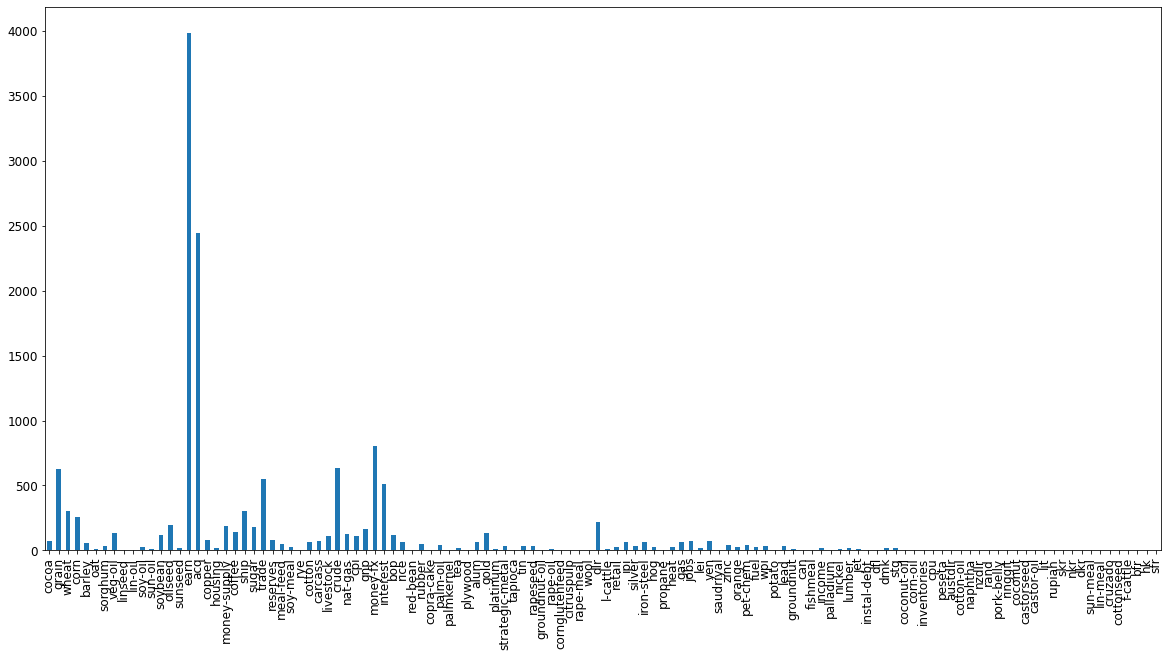

In [315]:
import pandas
from collections import Counter
import matplotlib.pyplot as plt
topic_counts = Counter(all_y)
print(type(topic_counts))

df = pandas.DataFrame.from_dict(topic_counts, orient='index')

#newlist = y.index(['earn','acq'])
ax = df.plot(kind='bar', legend = None, figsize = (20,10), fontsize = 12)



In [316]:
X

<11367x16298 sparse matrix of type '<class 'numpy.float64'>'
	with 582673 stored elements in Compressed Sparse Row format>

In [299]:
from sklearn.decomposition import NMF

In [300]:
nmf_model = NMF(n_components = 20, random_state = 42)

In [301]:
nmf_model.fit(X)

NMF(n_components=20, random_state=42)

In [302]:
len(vectorizer.get_feature_names())

16298

In [303]:
for index, topic in enumerate(nmf_model.components_):
    print(f'The top 15 words for topic # {index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

The top 15 words for topic # 0
['31', '19', '12', '18', 'sales', 'reuter', 'note', 'mths', 'shrs', 'avg', 'revs', 'net', 'shr', 'cts', 'vs']


The top 15 words for topic # 1
['revenues', 'results', 'fourth', 'reported', 'fiscal', 'expects', '1987', 'sales', '1986', 'share', 'company', 'year', 'earnings', 'said', 'quarter']


The top 15 words for topic # 2
['qtr', 'june', '20', '30', '10', 'reuter', '15', 'vs', 'april', 'record', 'prior', 'pay', 'qtly', 'div', 'cts']


The top 15 words for topic # 3
['credits', '600', 'slaughter', '700', 'ago', '100', '20', 'cts', 'includes', '500', 'shrs', 'year', 'avg', 'sales', '000']


The top 15 words for topic # 4
['losses', 'qtr', 'ct', 'dlr', 'operations', 'note', 'discontinued', 'year', 'cts', 'net', 'includes', 'shr', 'revs', 'vs', 'loss']


The top 15 words for topic # 5
['acquisition', 'exchange', 'securities', 'investment', 'outstanding', 'stake', 'pct', 'offer', 'group', 'stock', 'common', 'corp', 'company', 'said', 'shares']


The top 15 

# Attaching Discoverd Topic Labels to Original Articles 

In [304]:
X.shape

(11367, 16298)

In [305]:
len(corpus_df)

11367

In [306]:
topic_results = nmf_model.transform(X)

In [307]:
topic_results.shape

(11367, 20)

In [308]:
topic_results[1]

array([2.79892778e-05, 0.00000000e+00, 3.67962608e-03, 4.30121209e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.90165121e-02,
       1.68224014e-02, 0.00000000e+00, 3.04294632e-03, 0.00000000e+00,
       6.23582410e-03, 0.00000000e+00, 8.14320055e-03, 0.00000000e+00,
       2.20956846e-03, 1.63597266e-02, 6.60223357e-04, 1.83645497e-02])

In [309]:
topic_results[1].argmax()

7

In [310]:
corpus_df['Modeled Topic No.'] = topic_results.argmax(axis = 1)

In [311]:
corpus_df.head(10)

,Articles,Original Topic,Modeled Topic No.
0,Showers continued throughout the week in the B...,[cocoa],19
1,The U.S. Agriculture Department reported the f...,"[grain, wheat, corn, barley, oat, sorghum]",7
2,Argentine grain board figures show crop regist...,"[veg-oil, linseed, lin-oil, soy-oil, sun-oil, ...",7
3,Champion Products Inc said its board of direct...,[earn],11
4,Computer Terminal Systems Inc said it has comp...,[acq],5
5,"Shr 34 cts vs 1.19 dlrs Net 807,000 vs 2,858,0...",[earn],0
6,"Ohio Mattress Co said its first quarter, endin...","[earn, acq]",1
7,Oper shr loss two cts vs profit seven cts Oper...,[earn],13
8,Shr one dlr vs 73 cts Net 12.6 mln vs 15.8 mln...,[earn],0
9,Dean Foods Co expects earnings for the fourth ...,[earn],1


Counter({5: 2119, 0: 2028, 6: 837, 7: 823, 12: 812, 8: 647, 14: 586, 2: 454, 19: 451, 4: 344, 1: 336, 13: 327, 10: 297, 15: 284, 11: 232, 9: 189, 18: 175, 17: 173, 16: 154, 3: 99})


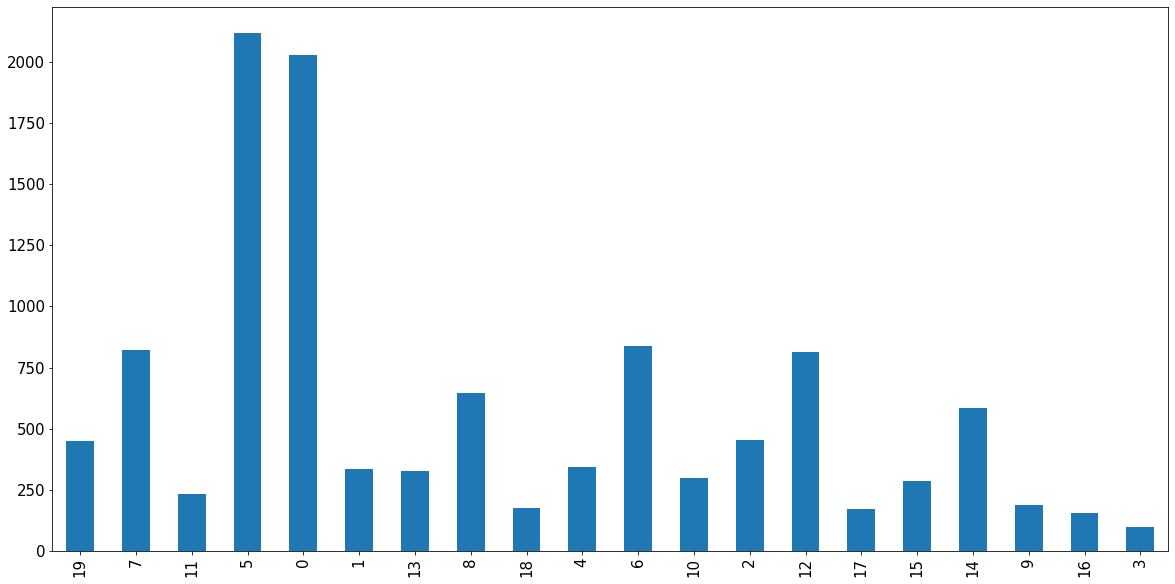

In [312]:
topic_counts2 = Counter(corpus_df['Modeled Topic No.'])
print(topic_counts2)
df = pandas.DataFrame.from_dict(topic_counts2, orient='index')

#newlist = y.index(['earn','acq'])
ax = df.plot(kind='bar', legend = None, figsize = (20,10), fontsize = 15)